In [1]:
from keras import models
from keras import layers
from keras import metrics
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data Loading and Inspection

In [2]:
df = pd.read_csv("SPAM text message 20170820 - Data.csv")

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.columns = ['labels', 'text']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


ham     0.865937
spam    0.134063
Name: labels, dtype: float64


C:\Users\gokce\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


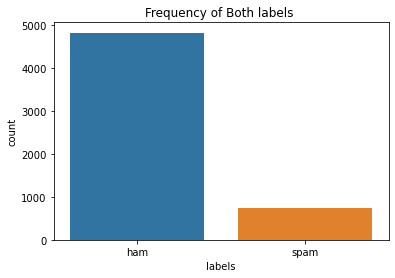

In [5]:
sns.countplot(df.labels)
plt.title('Frequency of Both labels ')
print(df.labels.value_counts(normalize = True))

  ## Universal Sentence Encoder Approach

In [6]:
#train/test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['text'], df['labels'],
                                                   stratify=df['labels'], random_state=42)

In [7]:
#turn y into numerical dummy to make sure the module.fit method works
y_train.replace({"spam": 1, "ham":0}, inplace = True)
y_test.replace({"spam": 1, "ham":0}, inplace = True)


# %pip install tensorflow-hub

In [8]:
# To use text data as features for models, we need to convert it into a numeric form. Tensorflow Hub provides various modules for
# converting the sentences into embeddings. Universal Sentence Encoder is one of the popular modules for generating sentence 
# embeddings. It gives back a 512 fixed-size vector for each word. Below we download this embedding module and provide and try 
# it out on one word.

# The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, 
# semantic similarity, clustering and other natural language tasks.The model is trained and optimized for greater-than-word 
# length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks 
# with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length
# English text and the output is a 512 dimensional vector. We apply this model to the STS benchmark for semantic similarity, and 
# the results can be seen in the example notebook made available. The universal-sentence-encoder model is trained with a deep 
# averaging network (DAN) encoder.

import tensorflow_hub as hub

encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
encoder(['Hello World'])


<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-2.60742623e-02, -8.46000165e-02, -2.67866198e-02,
         5.67842238e-02,  6.19704723e-02,  3.82260159e-02,
         2.01149322e-02,  2.74087600e-02,  8.69831964e-02,
         3.07917856e-02,  4.10411730e-02,  2.55183410e-02,
         9.65186686e-04,  5.89279681e-02,  4.00954075e-02,
         4.67089340e-02, -3.31279561e-02,  4.07041609e-02,
        -1.19929696e-02, -4.76170518e-02, -8.29668250e-03,
         7.05467463e-02,  4.84353630e-03,  8.09824765e-02,
        -5.70177250e-02, -6.43551499e-02,  6.97147325e-02,
        -6.98838457e-02,  2.64606159e-02, -2.35220511e-02,
         5.52375205e-02,  4.91363928e-02,  5.69897182e-02,
        -6.10719360e-02,  3.60850990e-02,  2.32446156e-02,
         5.60175218e-02, -1.09551996e-02,  4.21308316e-02,
        -1.76953934e-02,  7.12434622e-03,  2.04703063e-02,
        -7.10126385e-02, -8.45577493e-02,  4.36058566e-02,
         4.79397699e-02, -9.01802033e-02, -6.87343776e-02,
      

In [12]:
#create sequential model
model_1 = tf.keras.models.Sequential()

In [13]:
#add the layer with the universal sentence encoder
model_1.add(hub.KerasLayer(encoder, 
                        input_shape=[], 
                        dtype=tf.string, 
                        trainable=True))

In [14]:
# add the output layer, with only 1 neuron as our classification task is binary (spam or ham) and activation function sigmoid 
# as we want a probabilistic output 
model_1.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = 'l2'))
model_1.add(tf.keras.layers.Dropout(0.2))
model_1.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [15]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 256,814,273
Trainable params: 256,814,273
Non-trainable params: 0
_________________________________________________________________


In [16]:
#set some hyperparameters and select metrics of interest
model_1.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [17]:
#train the model and record the training history.
history_1 = model_1.fit(x_train,
          y_train,
          epochs=8,
         validation_data=(x_test, y_test))

Train on 4179 samples, validate on 1393 samples
Epoch 1/8
4179/4179 [==============================] - 277s 66ms/sample - loss: 0.4333 - binary_accuracy: 0.9430 - precision: 0.8797 - recall: 0.6661 - val_loss: 0.1851 - val_binary_accuracy: 0.9777 - val_precision: 0.9756 - val_recall: 0.8556
Epoch 2/8
4179/4179 [==============================] - 289s 69ms/sample - loss: 0.1283 - binary_accuracy: 0.9933 - precision: 0.9890 - recall: 0.9607 - val_loss: 0.1211 - val_binary_accuracy: 0.9864 - val_precision: 0.9884 - val_recall: 0.9091
Epoch 3/8
4179/4179 [==============================] - 265s 63ms/sample - loss: 0.0768 - binary_accuracy: 0.9978 - precision: 0.9982 - recall: 0.9857 - val_loss: 0.1014 - val_binary_accuracy: 0.9821 - val_precision: 0.9175 - val_recall: 0.9519
Epoch 4/8
4179/4179 [==============================] - 269s 64ms/sample - loss: 0.0508 - binary_accuracy: 0.9990 - precision: 1.0000 - recall: 0.9929 - val_loss: 0.0809 - val_binary_accuracy: 0.9885 - val_precision: 0.96

In [18]:
from keras.models import load_model
model_1.save("Universal_Sentence_Encoder_Model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: Universal_Sentence_Encoder_Model\assets


INFO:tensorflow:Assets written to: Universal_Sentence_Encoder_Model\assets


In [ ]:
#model_1 = load_model("Universal_Sentence_Encoder_Model.h5", custom_objects={'Precision': metrics.Precision(), 'Recall': metrics.Recall()})

In [19]:
score_1 = model_1.evaluate(x_test, y_test, batch_size=32)
print()
print("ACCURACY:",score_1[1])
print("LOSS:",score_1[0])

1393/1393 [==============================] - 0s 212us/sample - loss: 0.0723 - binary_accuracy: 0.9878 - precision: 0.9722 - recall: 0.9358

ACCURACY: 0.9877961
LOSS: 0.07232769189318221


#### Evaluation of the Model

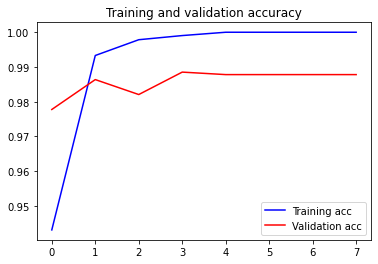

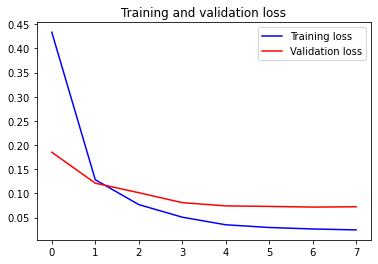

In [24]:
acc = history_1.history['binary_accuracy']
val_acc = history_1.history['val_binary_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [25]:
# make predictions on test data using the model
y_pred_1 = [1 if o>0.5 else 0 for o in model_1.predict(x_test)]
print(y_pred_1[:10])

[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1206
           1       0.97      0.94      0.95       187

    accuracy                           0.99      1393
   macro avg       0.98      0.97      0.97      1393
weighted avg       0.99      0.99      0.99      1393



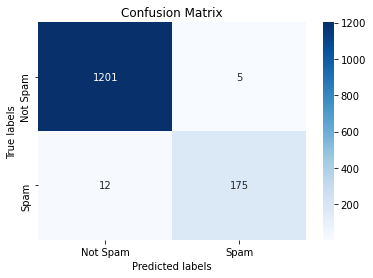

In [23]:
# create Confusion matrix
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import matplotlib.pyplot as plt
cf_matrix =confusion_matrix(y_test,y_pred_1)
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

## WORD2VEC APPROACH with LSTM

In [ ]:
#df[df['labels']=='ham'].value_counts()
#df[df['labels']=='spam'].value_counts()

In [67]:
X = df['text']
Y = df.labels

In [68]:
#encode labels

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
Y = le.fit_transform(Y)
Y

array([0, 0, 1, ..., 0, 0, 0])

In [69]:
Y = Y.reshape(-1,1)
Y

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [70]:
import nltk
from nltk.corpus import stopwords   #remove stopwords
from nltk.stem.porter import PorterStemmer   #stemming
import re
#Different models for converting text to vector
from sklearn.feature_extraction.text import CountVectorizer #BOW
from sklearn.feature_extraction.text import TfidfVectorizer    # Tf-idf
from gensim.models import Word2Vec   # word2vec method

In [71]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gokce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
port_stem=PorterStemmer()
corpus=[]
for i in range(len(df['text'])):
    text_1=re.sub('[^a-zA-Z]'," ",df['text'][i])
    text_1=text_1.lower()
    text_1=text_1.split()
    text_1=[port_stem.stem(word) for word in text_1 if word not in stopwords.words('english')]
    text_1=' '.join(text_1)
    corpus.append(text_1)

In [73]:
len(corpus), len(Y)

(5572, 5572)

In [74]:
from sklearn.model_selection import train_test_split
xtrain,xval,ytrain,yval=train_test_split(corpus,Y,stratify=Y,random_state=42)

In [75]:
len(xtrain),len(ytrain),len(xval),len(yval)

(4179, 4179, 1393, 1393)

In [76]:
%%time
documents=[text.split() for text in xtrain]

Wall time: 4 ms


In [77]:
len(documents)

4179

In [78]:
import gensim
w2v_model = gensim.models.Word2Vec(vector_size=300, 
                                            window=3, 
                                            min_count=5, 
                                            workers=4)
# min_count (int, optional) – Ignores all words with total frequency lower than this.
# workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).
# window (int, optional) – Maximum distance between the current and predicted word within a sentence.
# vector_size (int, optional) – Dimensionality of the word vectors.

In [79]:
# Build vocabulary from a dictionary of word frequencies.
w2v_model.build_vocab(documents)

In [80]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1295


In [81]:
#train word2vector model
w2v_model.train(documents,total_examples=len(documents),epochs=32)

(869579, 1205728)

In [82]:
w2v_model.wv.most_similar("answer")

[('question', 0.888487696647644),
 ('break', 0.8472680449485779),
 ('person', 0.8312538266181946),
 ('street', 0.7702011466026306),
 ('th', 0.7676493525505066),
 ('mid', 0.7640823721885681),
 ('share', 0.7612439393997192),
 ('countri', 0.7610010504722595),
 ('team', 0.755826473236084),
 ('peac', 0.7538736462593079)]

In [83]:
from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()

In [84]:
tokenizer.fit_on_texts(xtrain)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 5378


In [85]:
from keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(xtrain), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(xval), maxlen=300)

In [86]:
len(x_train),len(ytrain),len(x_test),len(yval)

(4179, 4179, 1393, 1393)

In [87]:
# Build Embedding Layer
import numpy as np
embedding_matrix = np.zeros((vocab_size, 300))
print(embedding_matrix)
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(5378, 300)


In [88]:
from keras.layers import Activation, Dense, Dropout, Embedding
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [89]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
# Build The model
model_2 = Sequential()
model_2.add(embedding_layer)
model_2.add(Dropout(0.2))
model_2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_2.add(Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          1613400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,706,905
Trainable params: 93,505
Non-trainable params: 1,613,400
_________________________________________________________________


In [90]:
model_2.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['binary_accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [91]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [92]:
history_2 = model_2.fit(x_train, ytrain,
                    batch_size=32,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 3761 samples, validate on 418 samples
Epoch 1/8
3761/3761 [==============================] - 22s 6ms/step - loss: 0.1065 - binary_accuracy: 0.9750 - precision_1: 0.9390 - recall_1: 0.7604 - val_loss: 0.0419 - val_binary_accuracy: 0.9904 - val_precision_1: 0.9483 - val_recall_1: 0.8653
Epoch 2/8


C:\Users\gokce\.conda\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_binary_accuracy,val_precision_1,val_recall_1,loss,binary_accuracy,precision_1,recall_1,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


3761/3761 [==============================] - 22s 6ms/step - loss: 0.0548 - binary_accuracy: 0.9848 - precision_1: 0.9567 - recall_1: 0.8811 - val_loss: 0.0574 - val_binary_accuracy: 0.9856 - val_precision_1: 0.9591 - val_recall_1: 0.8925
Epoch 3/8
3761/3761 [==============================] - 20s 5ms/step - loss: 0.0555 - binary_accuracy: 0.9835 - precision_1: 0.9580 - recall_1: 0.8984 - val_loss: 0.0295 - val_binary_accuracy: 0.9904 - val_precision_1: 0.9585 - val_recall_1: 0.9022
Epoch 4/8
3761/3761 [==============================] - 19s 5ms/step - loss: 0.0539 - binary_accuracy: 0.9838 - precision_1: 0.9591 - recall_1: 0.9074 - val_loss: 0.0320 - val_binary_accuracy: 0.9928 - val_precision_1: 0.9572 - val_recall_1: 0.9094
Epoch 5/8
3761/3761 [==============================] - 20s 5ms/step - loss: 0.0511 - binary_accuracy: 0.9854 - precision_1: 0.9591 - recall_1: 0.9113 - val_loss: 0.0273 - val_binary_accuracy: 0.9928 - val_precision_1: 0.9595 - val_recall_1: 0.9127
Epoch 6/8
3761/376

In [95]:
score_2 = model_2.evaluate(x_test, yval, batch_size=32)
print()
print("ACCURACY:",score_2[1])
print("LOSS:",score_2[0])

1393/1393 [==============================] - 3s 2ms/step

ACCURACY: 0.9827709794044495
LOSS: 0.07298089117039067


In [96]:
# see the keys of history
history_2.history.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'val_precision_1', 'val_recall_1', 'loss', 'binary_accuracy', 'precision_1', 'recall_1', 'lr'])

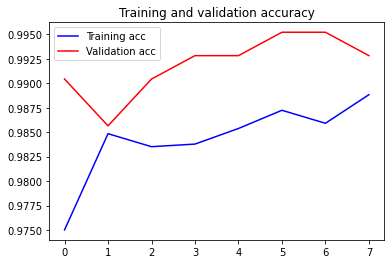

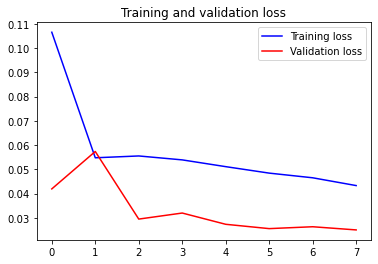

In [97]:
acc = history_2.history['binary_accuracy']
val_acc = history_2.history['val_binary_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [98]:
from keras.models import load_model
model_2.save("word2vec_LSTM_Model")

In [99]:
# make predictions on test data using the model
y_pred_2 = [1 if o>0.5 else 0 for o in model_2.predict(x_test)]
print(y_pred_2[:10])

[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]


In [100]:
from sklearn.metrics import classification_report
print(classification_report(yval, y_pred_2))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1206
           1       0.97      0.90      0.93       187

    accuracy                           0.98      1393
   macro avg       0.98      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393



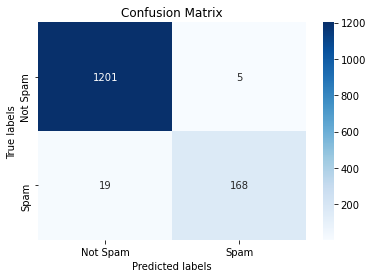

In [101]:
# create Confusion matrix
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import matplotlib.pyplot as plt
cf_matrix_2 =confusion_matrix(yval, y_pred_2)
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix_2, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);